In [22]:
import pandas as pd

dataframe = pd.read_csv("../data/raw/consumers-price-index-september-2023-quarter-tradables-and-non-tradables.csv")
dataframe.columns = dataframe.columns.str.lower()
columnas_numericas = dataframe.select_dtypes(include='number')
def eliminar_outliers(dataframe):
    for columna in columnas_numericas.columns:
        Q1 = dataframe[columna].quantile(0.25)
        Q3 = dataframe[columna].quantile(0.75)
        IQR = Q3 - Q1
        outlier_mask = (dataframe[columna] < (Q1 - 1.5 * IQR)) | (dataframe[columna] > (Q3 + 1.5 * IQR))
        return dataframe[~outlier_mask]
dataframe.columns = dataframe.columns.str.lower()
dataframe.drop_duplicates(subset=['series_reference'], keep="first", inplace=True)
cols = dataframe.columns[dataframe.isnull().mean() >= 0.5]
dataframe.drop(columns=cols, inplace=True)
dataframe.dropna(inplace=True)
dataframe = eliminar_outliers(dataframe)
dataframe.drop(dataframe[(dataframe['data_value']) < 0].index, axis=0, inplace=True)
dataframe.reset_index(drop=True, inplace=True)
for columna in columnas_numericas.columns.to_list():
    valor_medio = dataframe[columna].mean()
    dataframe[columna].fillna(valor_medio, inplace=True)
print(dataframe.describe())

             period    data_value
count  1.930000e+02    193.000000
mean   2.006060e+03   1070.599603
std    2.279650e-13   1479.222962
min    2.006060e+03    289.687138
25%    2.006060e+03    693.481276
50%    2.006060e+03    794.912560
75%    2.006060e+03    984.251969
max    2.006060e+03  11904.761905


In [23]:
def analizar_correlacion():
    """Analizar la correlacion del conjunto de datos"""
    correlacion = columnas_numericas.corr(method='pearson').stack().reset_index()
    correlacion.columns = ['variable_1', 'variable_2', 'r']
    correlacion = correlacion.loc[correlacion['variable_1'] != correlacion['variable_2'], :]
    correlacion['abs_r'] = abs(correlacion['r'])
    correlacion = correlacion.sort_values('abs_r', ascending=False)
    correlacion = correlacion.loc[correlacion['variable_1'] == 'data_value', 'abs_r']
    return correlacion
analizar_correlacion()

2    0.244362
Name: abs_r, dtype: float64

In [24]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def preprocesar_datos(X_train):
    """Preprocesar las columnas numericas y categoricas del conjunto de entrenamiento"""
    columnas_numericas = X_train.select_dtypes(include=['number']).columns.to_list()
    columnas_categoricas = X_train.select_dtypes(include=['object']).columns.to_list()
    transformacion_numerica = Pipeline(steps=[('scaler', StandardScaler())])
    transformacion_categorica = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])
    tupla_numerica = ('numerica', transformacion_numerica, columnas_numericas)
    tupla_categorica = ('categoria', transformacion_categorica, columnas_categoricas)
    transformers = [tupla_numerica, tupla_categorica]
    preprocesador = ColumnTransformer(transformers=transformers, remainder='passthrough', verbose_feature_names_out=False)
    return preprocesador.set_output(transform='pandas')
X_set = dataframe.drop('data_value', axis='columns')
y_set = dataframe['data_value']
X_train, X_test, y_train, y_test = train_test_split(X_set, y_set, test_size=0.2, random_state=123, shuffle=True)
preprocesador = preprocesar_datos(X_train)
modelo = Pipeline(steps=[('preprocesado', preprocesador), ('modelo', LinearRegression())])
modelo.fit(X_train, y_train)
prediccion = modelo.predict(X_test)
dataframe1 = pd.DataFrame({"data_value": y_test, "prediccion": prediccion})
print("Resultados del modelo:")
print(f"Scoring: {modelo.score(X_test, y_test)}")
print(f"Error del test: {mean_squared_error(y_true=y_test, y_pred=prediccion, squared=False)}")

Resultados del modelo:
Scoring: 0.02720388135138274
Error del test: 1836.4010230239476


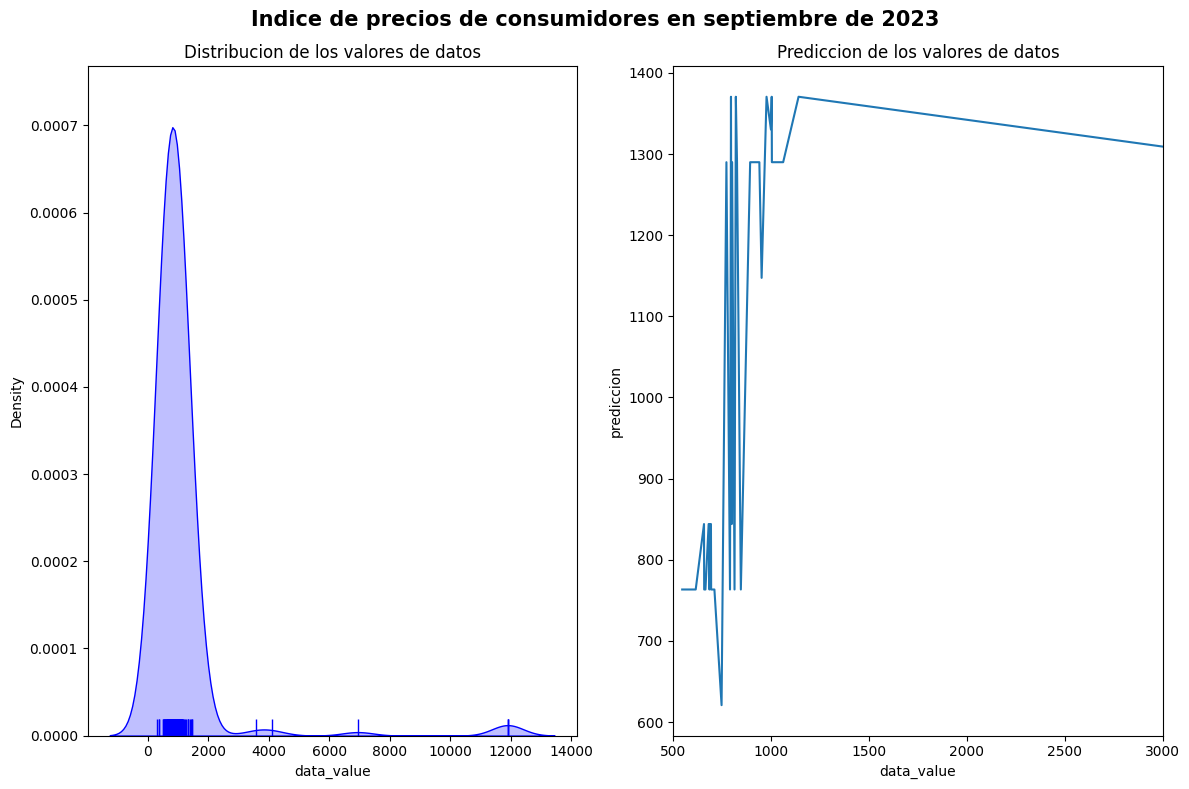

In [25]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

def graficar(dataset_limpio, dataset_prediccion):
    fig = plt.figure('Prediccion de valores', figsize=(12, 8))
    fig.suptitle("Indice de precios de consumidores en septiembre de 2023", fontsize=15, fontweight='bold')
    
    ax1 = fig.add_subplot(121)
    ax1.set(title="Distribucion de los valores de datos")
    ax2 = fig.add_subplot(122)
    ax2.set(title="Prediccion de los valores de datos", xlim=(500, 3000))
    
    sns.kdeplot(data=dataset_limpio['data_value'], fill=True, color='blue', ax=ax1)
    sns.rugplot(data=dataset_limpio['data_value'], color='blue', ax=ax1)
    sns.lineplot(data=dataset_prediccion, x="data_value", y="prediccion", ax=ax2)
    
    fig.tight_layout()
    plt.show()
graficar(dataframe, dataframe1)